<a href="https://colab.research.google.com/github/EdnaEze/Sentiment-Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


# Import Libraries

In [ ]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Load Dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/tripadvisor_hotel_reviews.csv')
dataset.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [ ]:
dataset['Rating'].nunique()

5

In [ ]:
dataset['Rating'].unique()

array([4, 2, 3, 5, 1])

In [ ]:
# Encode and name ratings into positive, neutral and negative sentiments

def ratings_encode(x):
  if x == 2 or x == 1:
    return 0
  if x == 3:
    return 1
  if x == 4 or x == 5:
    return 2

def ratings2name(x):
  if x == 0:
    return "Negative"
  if x == 1:
    return "Neutral"
  if x == 2:
    return "Positive"

dataset['labels'] = dataset['Rating'].apply(ratings_encode)
dataset['label_name'] = dataset['labels'].apply(ratings2name)
dataset.head()

,Review,Rating,labels,label_name
0,nice hotel expensive parking got good deal sta...,4,2,Positive
1,ok nothing special charge diamond member hilto...,2,0,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,2,Positive
4,"great stay great stay, went seahawk game aweso...",5,2,Positive


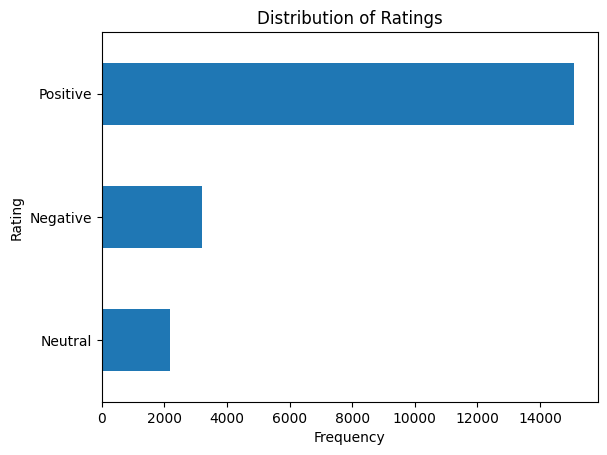

In [ ]:
dataset["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Distribution of Ratings")
plt.xlabel("Frequency")
plt.ylabel("Rating")
plt.show()

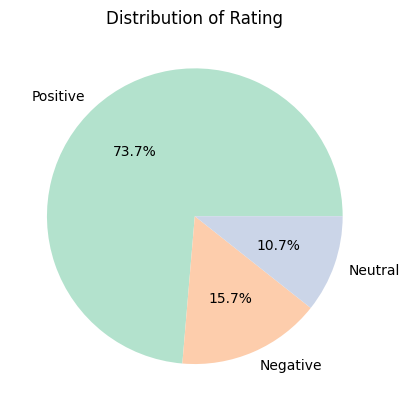

In [ ]:
# Count the occurrences of each label
Rating_counts = dataset['label_name'].value_counts()
# Create a pie chart
plt.pie(Rating_counts, labels=Rating_counts.index, colors = plt.cm.Pastel2.colors, autopct='%1.1f%%')
plt.title('Distribution of Rating')
plt.show()


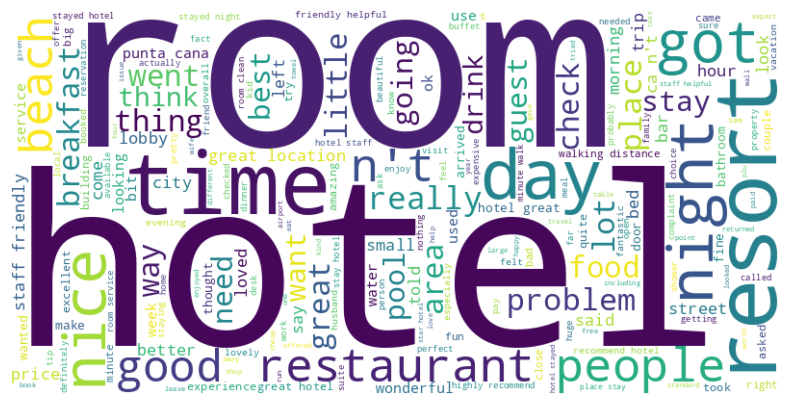

In [ ]:
# Join all reviews into a single string
all_reviews = ' '.join(dataset['Review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, prefer_horizontal=0.3, background_color='white', stopwords=STOPWORDS).generate(all_reviews)

# Display the image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Lenght of Reviews

Transformer models have a maximum input sequence length that is referred to as the **maximum context size**. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text.

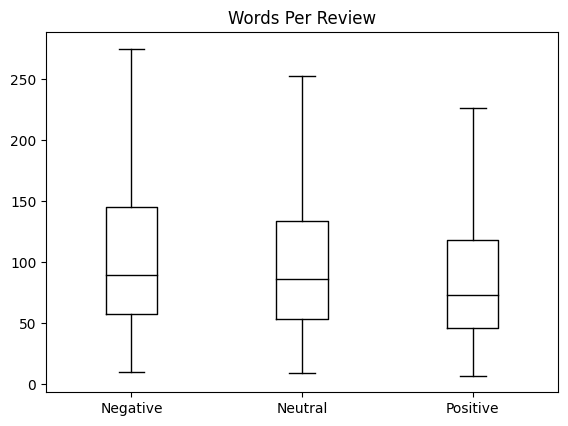

In [ ]:
dataset["Words Per Review"] = dataset["Review"].str.split().apply(len)
dataset.boxplot("Words Per Review", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each Rating most reviews are around 80 words long and the longest reviews are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

In [ ]:
dataset = dataset.drop(['Words Per Review'], axis=1)
dataset.head(3)

,Review,Rating,labels,label_name
0,nice hotel expensive parking got good deal sta...,4,2,Positive
1,ok nothing special charge diamond member hilto...,2,0,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral


# Tokenization

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus.

In [ ]:
# First convert pandas dataframe to Hugging face dataset object
dataset = Dataset.from_pandas(dataset)

In [ ]:
dataset

Dataset({
    features: ['Review', 'Rating', 'labels', 'label_name'],
    num_rows: 20491
})

In [ ]:
# df = dataset.train_test_split(test_size=0.1)
# print(df)

In [ ]:
#Create train, test and validation dataset
from datasets import DatasetDict

df_train_valid = dataset.train_test_split(test_size=0.09)
df_train = df_train_valid['train'].train_test_split(test_size=0.11)
dataset = {'train': df_train['train'], 'validation': df_train['test'], 'test': df_train_valid['test']}

dataset = DatasetDict(dataset)
dataset

DatasetDict({
    train: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 16594
    })
    validation: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 2052
    })
    test: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 1845
    })
})

### Subword Tokenization

The function below applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model's maximum context size. To see tokenize()

In [ ]:
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to tokenize and preprocess the text
def tokenize(batch):
  return tokenizer(batch["Review"], truncation=True, padding='max_length', max_length=512)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 16594
    })
    validation: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 2052
    })
    test: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 1845
    })
})

In [ ]:
# Apply the preprocessing function across all splits in the dataset
encoded_dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16594 [00:00<?, ? examples/s]

Map:   0%|          | 0/2052 [00:00<?, ? examples/s]

Map:   0%|          | 0/1845 [00:00<?, ? examples/s]

In [ ]:
print(encoded_dataset["train"].column_names)

['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask']


# Training the Text Classifier

### Load the weights of Pretrained model

In [ ]:
# Specify the model checkpoint
model_ckpt = "distilbert-base-uncased"

# Determine if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the DistilBERT model and move it to the selected device
model = DistilBertModel.from_pretrained(model_ckpt).to(device)

### Extract hidden state

In [ ]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
#Convert input_ids and attention_mask to torch format(tensors)

encoded_dataset.set_format("torch",
                            columns=["input_ids", "attention_mask", "Rating"])

In [ ]:
#Extract all hidden states across all splits

df_hidden = encoded_dataset.map(extract_hidden_states, batched=True, batch_size=32)

Map:   0%|          | 0/16594 [00:00<?, ? examples/s]

Map:   0%|          | 0/2052 [00:00<?, ? examples/s]

Map:   0%|          | 0/1845 [00:00<?, ? examples/s]

In [ ]:
df_hidden["train"].column_names

['Review',
 'Rating',
 'labels',
 'label_name',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [ ]:
df_hidden

DatasetDict({
    train: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16594
    })
    validation: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2052
    })
    test: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1845
    })
})

## Creating a feature matrix

In [ ]:
import numpy as np

X_train = np.array(df_hidden["train"]["hidden_state"])
X_val = np.array(df_hidden["validation"]["hidden_state"])
y_train = np.array(df_hidden["train"]["labels"])
y_val = np.array(df_hidden["validation"]["labels"])
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16594, 768), (2052, 768), (16594,), (2052,))

In [ ]:
y_val

array([2, 2, 0, ..., 1, 2, 0])

## Training a simple classifier

In [ ]:
lr_clf = LogisticRegression(max_iter = 3000, random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [ ]:
lr_clf.score(X_val, y_val)

0.8562378167641326

Looking at the accuracy, it might appear that the model is only a little better than random. Considering the fact that that the dataset is unbalanced, it is significantly better.

### Compare to a dummy classifier

The dummy classifier is used to build a classifier with simple heuristics.

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy= "most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

dummy_clf.score(X_val, y_val)

0.7397660818713451

Given the accuracy result from the dummy classifier we can say the logistics regression classifier with DistilBERT embeddings is better than the baseline/dummy classifier.

### Investigate performance with confusion matrix

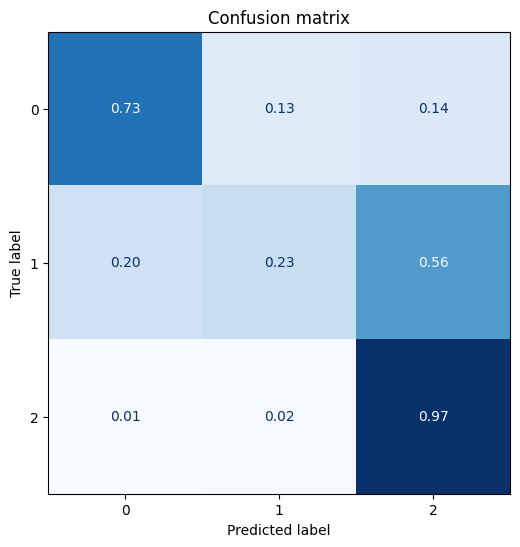

In [ ]:
def plot_confusion_matrix(y_preds, y_true):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_val)
plot_confusion_matrix(y_preds, y_val)

From the confusion we can see that the model was able to predict review 5 an 1 correctly to high degree (0.79, 0.62). The model had some difficulty differentiating between review 4 and 5 - from the confusion matrix we can see the model often confused review for 4 for 5.

# Fine-Tuning Transformers

With fine-tuning approach the hidden states are not used as fixed features, instead they are trained. Training the hidden states that serve as inputs to the classification model will help avoid the problem of working with dat that may not be well suited for classification tasks. Instead, the initial hidden states adapt during training to decress the model loss and this increase performance.

## Loading pretrained model

In [ ]:
#from transformers import AutoModelForSequenceClassification
from transformers import DistilBertForSequenceClassification


num_classes = 3
# model = (AutoModelForSequenceClassification
#          .from_pretrained(model_ckpt, num_labels=num_labels)
#          .to(device))

model = (DistilBertForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_classes)
         .to(device))

In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

## Define performance metrics

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

## Train the model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

#### Traing Parameters

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(encoded_dataset["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-tripadvisor"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

#### Instantiate and fine-tune model with 'Trainer'

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_dataset["train"],
                  eval_dataset=encoded_dataset["validation"],
                  tokenizer=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.385700,0.314988,0.878655,0.869786
